# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
!pip install scikit-learn --upgrade

    100% |████████████████████████████████| 20.0MB 1.9MB/s eta 0:00:01  4% |█▌                              | 942kB 10.1MB/s eta 0:00:02    7% |██▌                             | 1.6MB 14.1MB/s eta 0:00:02    15% |█████                           | 3.2MB 19.7MB/s eta 0:00:01    20% |██████▌                         | 4.1MB 18.6MB/s eta 0:00:01    25% |████████▏                       | 5.1MB 20.5MB/s eta 0:00:01    30% |█████████▉                      | 6.1MB 20.4MB/s eta 0:00:01    35% |███████████▍                    | 7.1MB 18.4MB/s eta 0:00:01    40% |█████████████                   | 8.1MB 20.3MB/s eta 0:00:01    45% |██████████████▌                 | 9.0MB 18.0MB/s eta 0:00:01    55% |█████████████████▋              | 11.0MB 20.9MB/s eta 0:00:01    78% |█████████████████████████       | 15.6MB 19.8MB/s eta 0:00:01    87% |████████████████████████████    | 17.5MB 15.7MB/s eta 0:00:01
    100% |████████████████████████████████| 13.4MB 2.6MB/s eta 0:00:01  8% |██▊                       

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data_transform import data_transform

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

import pickle

# magic word for producing visualizations in notebook
%matplotlib inline
sns.set_style()

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
%%time
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', nrows=600e3)
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

<string>:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 38.2 s, sys: 45.3 s, total: 1min 23s
Wall time: 3min 50s


In [ ]:
azdias.info(null_counts=True, verbose=True)

In [ ]:
customers.info(null_counts=True, verbose=True)

In [15]:
print(azdias.shape[1])

366


Start cleaning data
success: replacing AGER_TYP column keys to Nan
success: replacing ALTERSKATEGORIE_GROB column keys to Nan
success: replacing ALTER_HH column keys to Nan
success: replacing ANREDE_KZ column keys to Nan
success: replacing BALLRAUM column keys to Nan
success: replacing BIP_FLAG column keys to Nan
success: replacing CAMEO_DEUG_2015 column keys to Nan
success: replacing CAMEO_DEUINTL_2015 column keys to Nan
success: replacing CJT_GESAMTTYP column keys to Nan
success: replacing D19_BANKEN_ANZ_12 column keys to Nan
success: replacing D19_BANKEN_ANZ_24 column keys to Nan
success: replacing D19_BANKEN_DATUM column keys to Nan
success: replacing D19_BANKEN_DIREKT_ column keys to Nan
success: replacing D19_BANKEN_GROSS_ column keys to Nan
success: replacing D19_BANKEN_LOKAL_ column keys to Nan
success: replacing D19_BANKEN_OFFLINE_DATUM column keys to Nan
success: replacing D19_BANKEN_ONLINE_DATUM column keys to Nan
success: replacing D19_BANKEN_ONLINE_QUOTE_12 column keys to 

success: replacing KBA13_CCM2 column keys to Nan
success: replacing KBA05_CCM3 column keys to Nan
success: replacing KBA13_CCM3 column keys to Nan
success: replacing KBA05_CCM4 column keys to Nan
success: replacing KBA13_CCM4 column keys to Nan
success: replacing KBA05_DIESEL column keys to Nan
success: replacing KBA13_DIESEL column keys to Nan
success: replacing KBA05_FRAU column keys to Nan
success: replacing KBA13_FRAU column keys to Nan
success: replacing KBA05_GBZ column keys to Nan
success: replacing KBA13_GBZ column keys to Nan
success: replacing KBA05_HERST1 column keys to Nan
success: replacing KBA13_HERST1 column keys to Nan
success: replacing KBA05_HERST2 column keys to Nan
success: replacing KBA13_HERST2 column keys to Nan
success: replacing KBA05_HERST3 column keys to Nan
success: replacing KBA13_HERST3 column keys to Nan
success: replacing KBA05_HERST4 column keys to Nan
success: replacing KBA13_HERST4 column keys to Nan
success: replacing KBA05_HERST5 column keys to Nan


success: replacing KBA13_BJ_2006 column keys to Nan
success: replacing KBA13_BJ_2008 column keys to Nan
success: replacing KBA13_BJ_2009 column keys to Nan
success: replacing KBA13_BMW column keys to Nan
success: replacing KBA13_CCM_1000 column keys to Nan
success: replacing KBA13_CCM_1200 column keys to Nan
success: replacing KBA13_CCM_1400 column keys to Nan
success: replacing KBA13_CCM_0_1400 column keys to Nan
success: replacing KBA13_CCM_1500 column keys to Nan
success: replacing KBA13_CCM_1400_2500 column keys to Nan
success: replacing KBA13_CCM_1600 column keys to Nan
success: replacing KBA13_CCM_1800 column keys to Nan
success: replacing KBA13_CCM_2000 column keys to Nan
success: replacing KBA13_CCM_2500 column keys to Nan
success: replacing KBA13_CCM_2501 column keys to Nan
success: replacing KBA13_CCM_3000 column keys to Nan
success: replacing KBA13_CCM_3001 column keys to Nan
success: replacing KBA13_FAB_ASIEN column keys to Nan
success: replacing KBA13_FAB_SONSTIGE column k

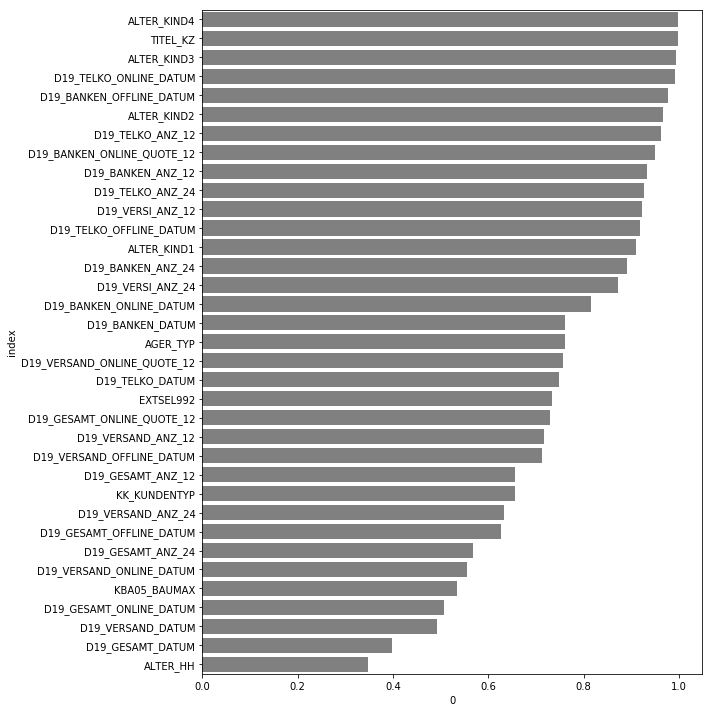

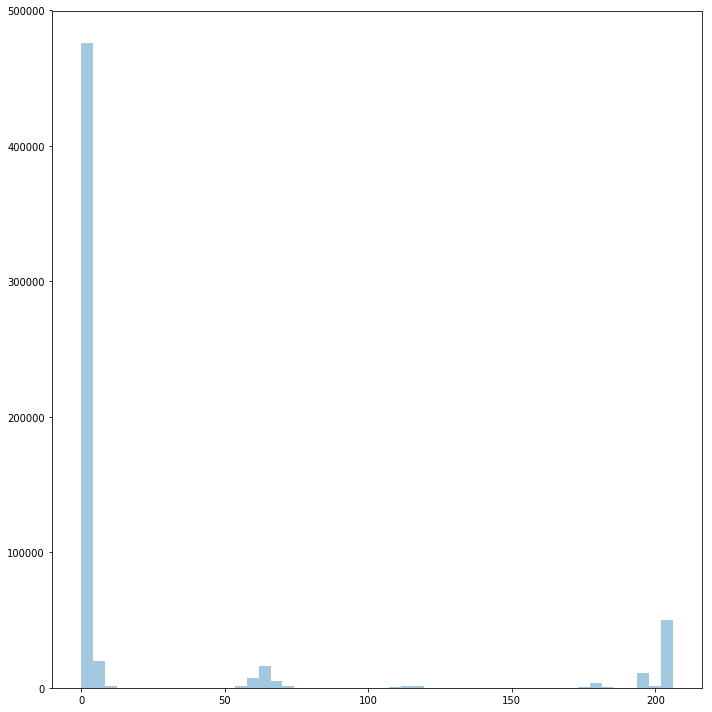

In [16]:
%%time
azdias = data_transform.clean_transform_data(azdias, train= True)

In [17]:
print(azdias.shape[1])

274


In [18]:
df_col_actions = data_transform.load_col_actions(azdias)

Perform custom transformation

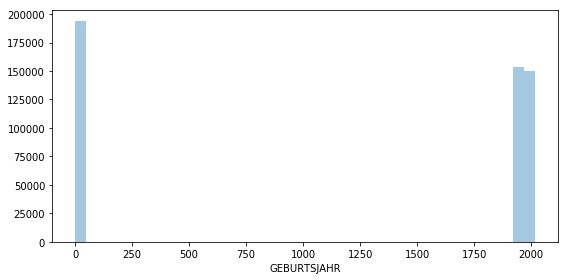

In [34]:
fig,ax = plt.subplots(figsize=(8,4))
sns.distplot(azdias['GEBURTSJAHR'],kde=False)
fig.tight_layout()
fig.savefig("Images/GEBURTSJAHR_dist_before_transformation.png")

In [35]:
%%time
dnt = data_transform.data_null_transform()
dnt.fit(azdias)

CPU times: user 1.25 s, sys: 10.7 s, total: 11.9 s
Wall time: 35.5 s


In [36]:
%%time
azdias_transform = dnt.transform(azdias)

CPU times: user 2.33 s, sys: 17.7 s, total: 20 s
Wall time: 2min 32s


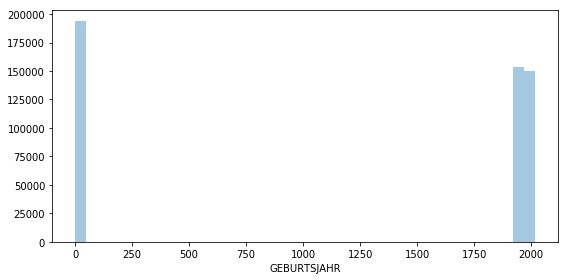

In [37]:
fig,ax = plt.subplots(figsize=(8,4))
c3 = azdias['GEBURTSJAHR'].isna()
sns.distplot(azdias_transform.loc[~c3,'GEBURTSJAHR'],kde=False)
fig.tight_layout()
fig.savefig("Images/GEBURTSJAHR_dist_after_transformation.png")

Check for percentage of null values in each category 

In [19]:
len(df_col_actions)
c0 = df_col_actions['CATEGORY'] == 'categorical'
for col in df_col_actions.loc[c0,'COLUMN']:
    print(col)
    null_val = azdias[col].isna().mean()
    print(null_val)
    if null_val > 0.1:
        display(azdias[col].value_counts(normalize=True))
    print()

BALLRAUM
0.0006338193956783578

CAMEO_DEUG_2015
0.004390456893238656

CJT_GESAMTTYP
0.006002169070820766

D19_BANKEN_DIREKT
0.0

D19_BANKEN_GROSS
0.0

D19_BANKEN_LOKAL
0.0

D19_BANKEN_REST
0.0

D19_BEKLEIDUNG_GEH
0.0

D19_BEKLEIDUNG_REST
0.0

D19_BILDUNG
0.0

D19_BIO_OEKO
0.0

D19_DIGIT_SERV
0.0

D19_DROGERIEARTIKEL
0.0

D19_ENERGIE
0.0

D19_FREIZEIT
0.0

D19_GARTEN
0.0

D19_HANDWERK
0.0

D19_HAUS_DEKO
0.0

D19_KINDERARTIKEL
0.0

D19_KONSUMTYP
0.2221748254984537


9.0    0.405371
1.0    0.181704
4.0    0.122948
6.0    0.087568
3.0    0.085708
2.0    0.078224
5.0    0.038477
Name: D19_KONSUMTYP, dtype: float64


D19_KOSMETIK
0.0

D19_LEBENSMITTEL
0.0

D19_LOTTO
0.2221748254984537


0.0    0.767581
7.0    0.184459
6.0    0.041780
5.0    0.003063
3.0    0.002848
4.0    0.000137
2.0    0.000111
1.0    0.000021
Name: D19_LOTTO, dtype: float64


D19_NAHRUNGSERGAENZUNG
0.0

D19_RATGEBER
0.0

D19_REISEN
0.0

D19_SAMMELARTIKEL
0.0

D19_SCHUHE
0.0

D19_SONSTIGE
0.0

D19_TECHNIK
0.0

D19_TELKO_MOBILE
0.0

D19_TELKO_REST
0.0

D19_TIERARTIKEL
0.0

D19_VERSAND_REST
0.0

D19_VERSICHERUNGEN
0.0

D19_VOLLSORTIMENT
0.0

D19_WEIN_FEINKOST
0.0

EWDICHTE
0.0006338193956783578

FINANZTYP
0.0

GEBAEUDETYP
0.0

GEBAEUDETYP_RASTER
1.0060625328227901e-05

GFK_URLAUBERTYP
0.006002169070820766

KBA05_MAXHERST
0.0

KBA05_MAXSEG
0.0

KBA05_MAXVORB
0.0

KBA05_MOTOR
0.0

KBA13_BAUMAX
0.0

KONSUMNAEHE
6.640012716630415e-05

LP_FAMILIE_GROB
0.006002169070820766

LP_LEBENSPHASE_GROB
0.006002169070820766

LP_STATUS_GROB
0.006002169070820766

NATIONALITAET_KZ
0.04275363339483729

OST_WEST_KZ
0.0

PLZ8_BAUMAX
0.004792881906367772

RETOURTYP_BK_S
0.006002169070820766

SHOPPER_TYP
0.04625875525919189

VERS_TYP
0.04625875525919189

WOHNLAGE
0.0

ZABEOTYP
0.0

ANREDE_KZ
0.0

ALTERSKATEGORIE_GROB
0.0

PRAEGENDE_JUGENDJAHRE_MOVEMENT
0.028755279313140987

PLZ8_BAU

In [20]:
len(df_col_actions)
c0 = df_col_actions['CATEGORY'] == 'ordinal'
for col in df_col_actions.loc[c0,'COLUMN']:
    print(col)
    null_val = azdias[col].isna().mean()
    print(null_val)
    if null_val > 0:
        display(azdias[col].value_counts(normalize=True))
    print()

FINANZ_ANLEGER
0.0

FINANZ_HAUSBAUER
0.0

FINANZ_MINIMALIST
0.0

FINANZ_SPARER
0.0

FINANZ_UNAUFFAELLIGER
0.0

FINANZ_VORSORGER
0.0

HEALTH_TYP
0.04625875525919189


3.0    0.417258
2.0    0.381747
1.0    0.200995
Name: HEALTH_TYP, dtype: float64


HH_EINKOMMEN_SCORE
0.0

INNENSTADT
0.0006338193956783578


5.0    0.184210
4.0    0.169631
6.0    0.139088
2.0    0.137088
3.0    0.118160
8.0    0.102514
7.0    0.084599
1.0    0.064709
Name: INNENSTADT, dtype: float64


KBA05_ALTER1
0.0

KBA05_ALTER2
0.0

KBA05_ALTER3
0.0

KBA05_ALTER4
0.0

KBA05_ANHANG
0.0

KBA05_ANTG1
0.0

KBA05_ANTG2
0.0

KBA05_ANTG3
0.0

KBA05_ANTG4
0.0

KBA05_AUTOQUOT
8.04850026258232e-06


3.0    0.348537
4.0    0.262929
2.0    0.165273
1.0    0.111678
5.0    0.111583
Name: KBA05_AUTOQUOT, dtype: float64


KBA05_CCM1
0.0

KBA05_CCM2
0.0

KBA05_CCM3
0.0

KBA05_CCM4
0.0

KBA05_DIESEL
0.0

KBA05_FRAU
0.0

KBA05_GBZ
0.0

KBA05_HERST1
0.0

KBA05_HERST2
0.0

KBA05_HERST3
0.0

KBA05_HERST4
0.0

KBA05_HERST5
0.0

KBA05_HERSTTEMP
0.004933730660962963


3.0    0.371007
1.0    0.220098
2.0    0.215028
4.0    0.158041
5.0    0.035826
Name: KBA05_HERSTTEMP, dtype: float64


KBA05_KRSAQUOT
0.0

KBA05_KRSHERST1
0.0

KBA05_KRSHERST2
0.0

KBA05_KRSHERST3
0.0

KBA05_KRSKLEIN
0.0

KBA05_KRSOBER
0.0

KBA05_KRSVAN
0.0

KBA05_KRSZUL
0.0

KBA05_KW1
0.0

KBA05_KW2
0.0

KBA05_KW3
0.0

KBA05_MAXAH
0.0

KBA05_MAXBJ
0.0

KBA05_MOD1
0.0

KBA05_MOD2
0.0

KBA05_MOD3
0.0

KBA05_MOD4
0.0

KBA05_MOD8
0.0

KBA05_MODTEMP
0.0

KBA05_MOTRAD
0.0

KBA05_SEG1
0.0

KBA05_SEG10
0.0

KBA05_SEG2
0.0

KBA05_SEG3
0.0

KBA05_SEG4
0.0

KBA05_SEG5
0.0

KBA05_SEG6
0.0

KBA05_SEG7
0.0

KBA05_SEG8
0.0

KBA05_SEG9
0.0

KBA05_VORB0
0.0

KBA05_VORB1
0.0

KBA05_VORB2
0.0

KBA05_ZUL1
0.0

KBA05_ZUL2
0.0

KBA05_ZUL3
0.0

KBA05_ZUL4
0.0

KBA13_ALTERHALTER_30
0.0

KBA13_ALTERHALTER_45
0.0

KBA13_ALTERHALTER_60
0.0

KBA13_ALTERHALTER_61
0.0

KBA13_AUDI
0.0

KBA13_AUTOQUOTE
0.0

KBA13_BJ_1999
0.0

KBA13_BJ_2000
0.0

KBA13_BJ_2004
0.0

KBA13_BJ_2006
0.0

KBA13_BJ_2008
0.0

KBA13_BJ_2009
0.0

KBA13_BMW
0.0

KBA13_CCM_0_1400
0.0

KBA13_CCM_1000
0.0

KBA13_CCM_1200
0.0

KBA13_CCM_1400
0.0

KBA13_CCM_1500
0.

4.0    0.195456
3.0    0.194634
1.0    0.189901
2.0    0.183804
5.0    0.158359
0.0    0.077846
Name: ONLINE_AFFINITAET, dtype: float64


ORTSGR_KLS9
0.005211403920022053


5.0    0.187871
4.0    0.144801
7.0    0.130834
9.0    0.115203
3.0    0.103880
6.0    0.096886
8.0    0.093241
2.0    0.078152
1.0    0.049133
Name: ORTSGR_KLS9, dtype: float64


PLZ8_ANTG1
0.004792881906367772


2.0    0.350425
3.0    0.285733
1.0    0.243962
4.0    0.112912
0.0    0.006967
Name: PLZ8_ANTG1, dtype: float64


PLZ8_ANTG2
0.004792881906367772


3.0    0.399745
2.0    0.274862
4.0    0.249892
1.0    0.066227
0.0    0.009274
Name: PLZ8_ANTG2, dtype: float64


PLZ8_ANTG3
0.004792881906367772


2.0    0.329483
1.0    0.306948
3.0    0.212663
0.0    0.150906
Name: PLZ8_ANTG3, dtype: float64


PLZ8_ANTG4
0.004792881906367772


0.0    0.457355
1.0    0.384723
2.0    0.157922
Name: PLZ8_ANTG4, dtype: float64


PLZ8_GBZ
0.004792881906367772


3.0    0.372847
4.0    0.233827
5.0    0.197182
2.0    0.144449
1.0    0.051696
Name: PLZ8_GBZ, dtype: float64


PLZ8_HHZ
0.004792881906367772


3.0    0.402410
4.0    0.273819
5.0    0.226348
2.0    0.084061
1.0    0.013362
Name: PLZ8_HHZ, dtype: float64


RELAT_AB
0.005332131423960788


3.0    0.344801
5.0    0.224428
1.0    0.176760
2.0    0.131344
4.0    0.122667
Name: RELAT_AB, dtype: float64


SEMIO_DOM
0.0

SEMIO_ERL
0.0

SEMIO_FAM
0.0

SEMIO_KAEM
0.0

SEMIO_KRIT
0.0

SEMIO_KULT
0.0

SEMIO_LUST
0.0

SEMIO_MAT
0.0

SEMIO_PFLICHT
0.0

SEMIO_RAT
0.0

SEMIO_REL
0.0

SEMIO_SOZ
0.0

SEMIO_TRADV
0.0

SEMIO_VERT
0.0

W_KEIT_KIND_HH
0.07337616476889737


6.0    0.382644
4.0    0.180385
3.0    0.128055
2.0    0.113226
1.0    0.106093
5.0    0.089597
Name: W_KEIT_KIND_HH, dtype: float64


WOHNDAUER_2008
0.0

PRAEGENDE_JUGENDJAHRE_DECADE
0.028755279313140987


6.0    0.288674
4.0    0.228295
5.0    0.193646
3.0    0.154010
2.0    0.099027
1.0    0.036348
Name: PRAEGENDE_JUGENDJAHRE_DECADE, dtype: float64

In [23]:
len(df_col_actions)
c0 = df_col_actions['CATEGORY'] == 'binary'
for col in df_col_actions.loc[c0,'COLUMN']:
    print(col)
    null_val = azdias[col].isna().mean()
    print(null_val)
    print()

GREEN_AVANTGARDE
0.0



ANZ_HAUSHALTE_AKTIV


count    496987.000000
mean          8.160085
std          15.093002
min           0.000000
25%           2.000000
50%           4.000000
75%           9.000000
max         536.000000
Name: ANZ_HAUSHALTE_AKTIV, dtype: float64

skew:8.622337473728813
0.0

ANZ_HH_TITEL


count    496987.000000
mean          8.681841
std         130.032211
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1965.000000
Name: ANZ_HH_TITEL, dtype: float64

skew:14.978380947461158
0.0

ANZ_PERSONEN


count    496987.000000
mean          1.740657
std           1.164334
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          37.000000
Name: ANZ_PERSONEN, dtype: float64

skew:1.7080180101526952
0.0

ANZ_TITEL


count    496987.000000
mean          0.004105
std           0.067845
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.000000
Name: ANZ_TITEL, dtype: float64

skew:18.142506042974162
0.0

GEBURTSJAHR


count    496987.000000
mean       1964.565365
std          16.932564
min        1900.000000
25%        1951.000000
50%        1964.000000
75%        1977.000000
max        2017.000000
Name: GEBURTSJAHR, dtype: float64

skew:0.025018218194978153
0.0

KBA13_ANZAHL_PKW


count    496987.000000
mean        619.546250
std         337.659158
min           0.000000
25%         385.000000
50%         549.000000
75%         776.000000
max        2300.000000
Name: KBA13_ANZAHL_PKW, dtype: float64

skew:1.2645878564104551
0.0

MIN_GEBAEUDEJAHR


count    496987.000000
mean       1992.702338
std           1.814087
min        1985.000000
25%        1992.000000
50%        1992.000000
75%        1992.000000
max        2005.000000
Name: MIN_GEBAEUDEJAHR, dtype: float64

skew:3.0734685715007894
0.0



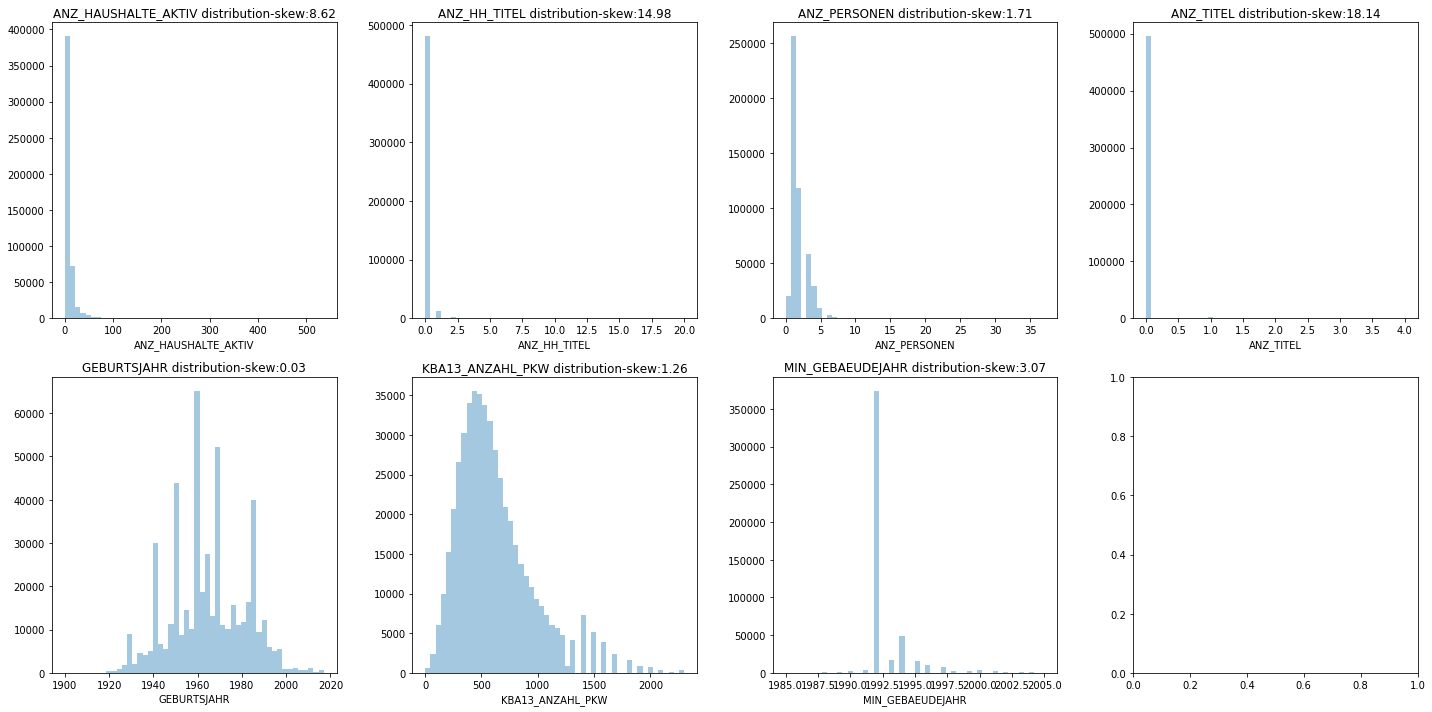

In [40]:
len(df_col_actions)
c0 = df_col_actions['CATEGORY'] == 'numeric'

fig,ax = plt.subplots(2,4,figsize=(20,10))

axes = ax.flatten()
for i, col in enumerate(df_col_actions.loc[c0,'COLUMN']):
    print(col)
    null_val = azdias_transform[col].isna().mean()
    display(azdias_transform[col].describe())
    print("skew:{}".format(azdias_transform[col].skew()))
    try:
        c0 = azdias[col].isna()
        sns.distplot(azdias_transform.loc[~c0,col], kde=False, ax=axes[i])
        axes[i].set_title("{} distribution-skew:{}".format(col,azdias_transform[col].skew().round(2)))
    except:
        continue
    print(null_val)
    print()

fig.tight_layout()
fig.savefig("Images/numeric_cols_dist.png")

In [112]:
# Check-point
# azdias_transform.to_csv('data_transform/azdias_transform.dsv',index=False,sep='|')
azdias_transform = pd.read_csv('data_transform/azdias_transform.dsv',sep='|')

In [6]:
df_col_actions = data_transform.load_col_actions(azdias)

# Pipeline

In [7]:
# categorical
categorical_pipeline = Pipeline([('cat_onehot',OneHotEncoder(handle_unknown='ignore', drop=None))])

c0 = df_col_actions['CATEGORY'] == 'categorical'
categorical_columns = [x for x in df_col_actions.loc[c0,'COLUMN']]

In [8]:
# binary
binary_pipeline = Pipeline([('binary_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

c0 = df_col_actions['CATEGORY'] == 'binary'
binary_columns = [x for x in df_col_actions.loc[c0,'COLUMN']]

In [9]:
# Ordinal
ordinal_pipeline = Pipeline([('ordinal_impute',SimpleImputer(missing_values= np.nan, strategy='most_frequent')),
                             ('ordinal_standarize',StandardScaler())])

c0 = df_col_actions['CATEGORY'] == 'ordinal'
ordinal_columns = [x for x in df_col_actions.loc[c0,'COLUMN']]

In [10]:
# Numerical 
'''
    fix geburtsjahr category fit to learn averages then transform
    solve for the skewed data apply logarithm x+1

    impute values
    scale values 
'''
#GEBURTSJAHR
num_cols = ['GEBURTSJAHR'] # do not apply log to this column
num_impute = ('num_impute', SimpleImputer(missing_values=np.nan, strategy='median'))
num_scale = ('num_scale', StandardScaler())

num_pipeline = Pipeline(steps=[num_impute, num_scale])


c0 = df_col_actions['CATEGORY'] == 'numeric'

log_cols = [x for x in df_col_actions.loc[c0,'COLUMN'].values if x not in num_cols]
log_transform = ('log_transform', FunctionTransformer(func = np.log1p, inverse_func=np.expm1, validate=False))
log_impute = ('log_impute', SimpleImputer(missing_values=np.nan, strategy='median'))
log_scale = ('log_scale', StandardScaler())

log_pipeline = Pipeline(steps=[log_transform,
                              log_impute,
                              log_scale])

numeric_pipeline = ColumnTransformer(transformers=[
    ('log',log_pipeline,log_cols),
    ('num',num_pipeline,num_cols)
])


c0 = df_col_actions['CATEGORY'] == 'numeric'
numeric_columns = [x for x in df_col_actions.loc[c0,'COLUMN'].values]

In [11]:
transformers = [('categorical',categorical_pipeline,categorical_columns),
               ('binary',binary_pipeline,binary_columns),
               ('ordinal',ordinal_pipeline,ordinal_columns),
               ('numerical',numeric_pipeline,numeric_columns)
               ]

ct = ColumnTransformer(transformers=transformers)

In [46]:
%%time
print(azdias_transform.shape)
azdias_transformed = ct.fit_transform(azdias_transform)
print(azdias_transformed.shape)

(496987, 274)
(496987, 656)
CPU times: user 14.2 s, sys: 36.4 s, total: 50.6 s
Wall time: 8min 42s


In [47]:
#Check point
pl = ct.named_transformers_['categorical']
cd = pl.named_steps['cat_onehot']
dummies_names = list(cd.get_feature_names())

#all columns for transformed data
column_names = dummies_names+list(binary_columns)+list(ordinal_columns)+list(numeric_columns)
azdias_transformed = pd.DataFrame(azdias_transformed, columns = column_names)

In [21]:
#azdias_transformed.to_csv('data_transform/azdias_transformed.dsv',index=False,sep='|')
azdias_transformed = pd.read_csv('data_transform/azdias_transformed.dsv',sep='|')

In [48]:
azdias_transformed[numeric_columns].describe()

ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN     ANZ_TITEL  \
count         4.969870e+05  4.969870e+05  4.969870e+05  4.969870e+05   
mean         -3.771551e-16 -3.721511e-17  6.253512e-17  1.589827e-17   
std           1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00   
min          -1.896163e+00 -1.084971e-01 -2.414664e+00 -6.161792e-02   
25%          -6.819245e-01 -1.084971e-01 -6.169024e-01 -6.161792e-02   
50%          -1.173358e-01 -1.084971e-01 -6.169024e-01 -6.161792e-02   
75%           6.487633e-01 -1.084971e-01  4.347207e-01 -6.161792e-02   
max           5.051420e+00  1.448209e+01  7.019858e+00  3.570235e+01   

        GEBURTSJAHR  KBA13_ANZAHL_PKW  MIN_GEBAEUDEJAHR  
count  4.969870e+05      4.969870e+05      4.969870e+05  
mean  -1.868562e-15     -1.543180e-12     -4.940074e-15  
std    1.000001e+00      1.000001e+00      1.000001e+00  
min   -1.115006e+01     -4.259556e+00     -3.813092e+00  
25%   -5.825428e-01     -3.873122e-01     -8.011414e-01  
50%    4.570745e-02     -3.873122e-01     -3.338924e-02  
75%    6.587716e-01     -3.873122e-01      7.343630e-01  
max    2.585070e+00      6.768051e+00      3.096677e+00

# PCA component

In [49]:
print("Current number of features: ", azdias_transformed.shape[1])

Current number of features:  656


In [50]:
%%time
pca = PCA()
azdias_pca = pca.fit_transform(azdias_transformed)

CPU times: user 14min 59s, sys: 2min 11s, total: 17min 10s
Wall time: 1h 50min 19s


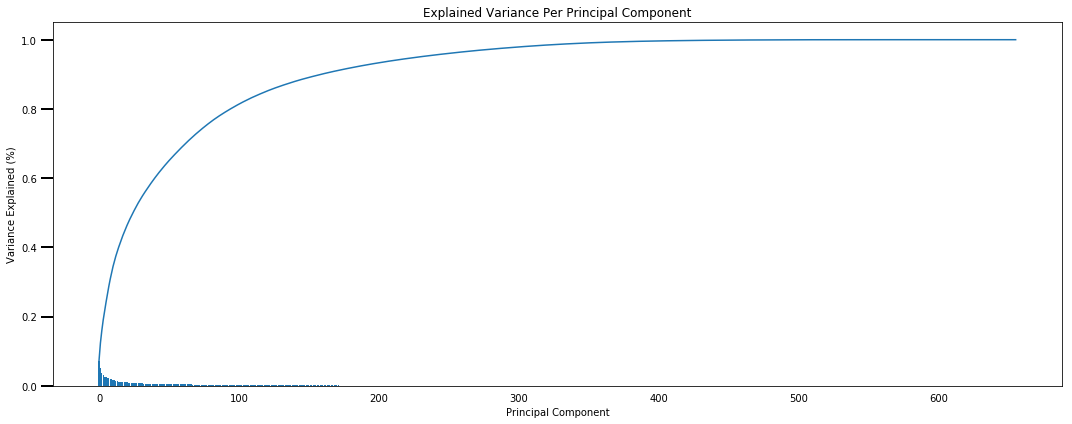

In [51]:
num_components=len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(15, 6))
ax = plt.subplot(111)
cumvals = np.cumsum(vals)
ax.bar(ind, vals)
ax.plot(ind, cumvals)

ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=2, length=12)

ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained (%)")
plt.title('Explained Variance Per Principal Component')


fig.tight_layout()
fig.savefig("Images/PCA_component_variance_graph.png")

In [52]:
n_components = 158 
print("Explained variance ratio for the first {} components is {}%.".
      format(n_components, sum(pca.explained_variance_ratio_[:n_components]).round(2)*100))

Explained variance ratio for the first 158 components is 90.0%.


In [26]:
%%time
n_components = 158 
pca = PCA(n_components)
azdias_pca = pca.fit_transform(azdias_transformed)
explained_var_ratio = sum(pca.explained_variance_ratio_)

CPU times: user 2min 54s, sys: 3min 30s, total: 6min 25s
Wall time: 23min 36s


In [4]:
# Checkpoint
# pd.DataFrame(azdias_pca).to_csv('data_transform/azdias_pca.dsv',index=False,sep='|')
azdias_pca = pd.read_csv('data_transform/azdias_pca.dsv',sep='|')

In [54]:
def pca_to_features(pca, n_component, column_names):
    '''
    Map weights for the component number to corresponding feature names
    
    Input:
        pca : object of pca class
        component (int): number of component to map to feature
        column_names (list(str)): column names of DataFrame before PCA transformation
    
    Output:
        df_features (DataFrame): DataFrame with feature weight sorted by feature name
    
    '''
    weights_array = pca.components_[n_component]
    df_features = pd.DataFrame(weights_array, index=column_names, columns=['weight'])
    return  df_features.sort_values(by='weight',ascending=False).round(2)

In [13]:
# Map weights for the third principal component to corresponding feature names
component = 0

for i in np.arange(5):
    
    feature_weights = data_transform.pca_to_features(pca, i, column_names)
    print("{} component variance:{}".format(i, pca.explained_variance_ratio_[i].round(2)*100))
    print("top five positive weight features and top five features with negative weights ")
    print(feature_weights[:5])
    print(feature_weights[-5:])
    print()

NameError: name 'pca' is not defined

In [ ]:
azdias_pca

# Kmeans clustering

In [ ]:
# find the better k number

batch_size=40000

scores = []
centers = list(range(1,31, 1))
for center in centers:
    print(center)
    kmeans = MiniBatchKMeans(n_clusters=center, batch_size=batch_size, random_state=42).fit(azdias_pca)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(azdias_pca)

    # Obtain a score related to the model fit
    score = np.abs(model.score(azdias_pca))
    scores.append(score)   


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [ ]:
# number of k vs scores

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K using MiniBatchKMeans');
plt.savefig("Images/Kmeans_elbow.png")

In [ ]:
d = np.subtract(scores[0:len(scores)-1],scores[1:len(scores)])

plt.plot(centers[:len(scores)-1], d, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('Change in SSE vs. K using MiniBatchKMeans');
plt.savefig("Images/Kmeans_shift_diff.png")

### Selection of parameters and clustering pipeline

In [29]:
%%time
n_clusters = 15
km = KMeans(n_clusters=n_clusters, random_state=42)

km.fit(azdias_pca)

CPU times: user 4min 43s, sys: 0 ns, total: 4min 43s
Wall time: 4min 53s


In [ ]:
general_predictions = km.predict(azdias_pca)
general_predictions[:20]

# Final Pipeline

In [117]:
n_components = 175
n_clusters = 15
cluster_pipeline = Pipeline([
                        ('null',dnt),
                        ('transform', ct), 
                        ('pca', PCA(n_components)),
                        ('kmeans', KMeans(n_clusters=n_clusters, random_state=42) )
                        ])

In [119]:
%%time
cluster_pipeline.fit(azdias)
train_preds =  cluster_pipeline.predict(azdias)
train_preds[:10]

CPU times: user 8min 52s, sys: 3min 24s, total: 12min 16s
Wall time: 53min 28s


In [120]:
train_preds[:10]

array([11, 13,  2,  4,  3,  3,  4,  5,  5,  6], dtype=int32)

In [121]:
# Save picke
pkl_filename = "Model/unsupervised_cluster_model.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(cluster_pipeline, file)

In [3]:
# Read pickle
pkl_filename = "Model/unsupervised_cluster_model.pkl"  
with open(pkl_filename, 'rb') as file:  
    pickle_model = pickle.load(file)
    
cluster_pipeline = pickle_model

In [ ]:
%%time
azdias = data_transform.clean_transform_data(azdias, train= False)
train_preds =  cluster_pipeline.predict(azdias)

Start cleaning data
success: replacing AGER_TYP column keys to Nan
success: replacing ALTERSKATEGORIE_GROB column keys to Nan
success: replacing ALTER_HH column keys to Nan
success: replacing ANREDE_KZ column keys to Nan
success: replacing BALLRAUM column keys to Nan
success: replacing BIP_FLAG column keys to Nan
success: replacing CAMEO_DEUG_2015 column keys to Nan
success: replacing CAMEO_DEUINTL_2015 column keys to Nan
success: replacing CJT_GESAMTTYP column keys to Nan
success: replacing D19_BANKEN_ANZ_12 column keys to Nan
success: replacing D19_BANKEN_ANZ_24 column keys to Nan
success: replacing D19_BANKEN_DATUM column keys to Nan
success: replacing D19_BANKEN_DIREKT_ column keys to Nan
success: replacing D19_BANKEN_GROSS_ column keys to Nan
success: replacing D19_BANKEN_LOKAL_ column keys to Nan
success: replacing D19_BANKEN_OFFLINE_DATUM column keys to Nan
success: replacing D19_BANKEN_ONLINE_DATUM column keys to Nan
success: replacing D19_BANKEN_ONLINE_QUOTE_12 column keys to 

success: replacing KBA05_MOTRAD column keys to Nan
success: replacing KBA13_MOTRAD column keys to Nan
success: replacing KBA05_SEG1 column keys to Nan
success: replacing KBA13_SEG1 column keys to Nan
success: replacing KBA05_SEG10 column keys to Nan
success: replacing KBA13_SEG10 column keys to Nan
success: replacing KBA05_SEG2 column keys to Nan
success: replacing KBA13_SEG2 column keys to Nan
success: replacing KBA05_SEG3 column keys to Nan
success: replacing KBA13_SEG3 column keys to Nan
success: replacing KBA05_SEG4 column keys to Nan
success: replacing KBA13_SEG4 column keys to Nan
success: replacing KBA05_SEG5 column keys to Nan
success: replacing KBA13_SEG5 column keys to Nan
success: replacing KBA05_SEG6 column keys to Nan
success: replacing KBA13_SEG6 column keys to Nan
success: replacing KBA05_SEG7 column keys to Nan
success: replacing KBA13_SEG7 column keys to Nan
success: replacing KBA05_SEG8 column keys to Nan
success: replacing KBA13_SEG8 column keys to Nan
success: repla

success: replacing KBA13_VW column keys to Nan
success: replacing KKK column keys to Nan
success: replacing NATIONALITAET_KZ column keys to Nan
success: replacing ORTSGR_KLS9 column keys to Nan
success: replacing OST_WEST_KZ column keys to Nan
success: replacing PLZ8_ANTG1 column keys to Nan
success: replacing PLZ8_ANTG2 column keys to Nan
success: replacing PLZ8_ANTG3 column keys to Nan
success: replacing PLZ8_ANTG4 column keys to Nan
success: replacing PLZ8_GBZ column keys to Nan
success: replacing PLZ8_HHZ column keys to Nan
success: replacing PRAEGENDE_JUGENDJAHRE column keys to Nan
success: replacing REGIOTYP column keys to Nan
success: replacing RELAT_AB column keys to Nan
success: replacing RETOURTYP_BK_S column keys to Nan
success: replacing SEMIO_DOM column keys to Nan
success: replacing SEMIO_ERL column keys to Nan
success: replacing SEMIO_FAM column keys to Nan
success: replacing SEMIO_KAEM column keys to Nan
success: replacing SEMIO_KRIT column keys to Nan
success: replacin

# Customer Preds

In [ ]:
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [ ]:
%%time
customers = data_transform.clean_transform_data(customers, train= False)

In [8]:
%%time
customers_predictions = cluster_pipeline.predict(customers)
customers_predictions[:20]

CPU times: user 5.65 s, sys: 10.7 s, total: 16.4 s
Wall time: 17.7 s


# Comparing Clusters

In [9]:
train_preds
customers_predictions

array([6, 1, 1, ..., 6, 4, 5], dtype=int32)

In [10]:
df_customer_preds = pd.DataFrame(customers_predictions)
df_train_preds = pd.DataFrame(train_preds)


print("length of customer {}".format(len(df_customer_preds)))
print("length of training {}".format(len(df_train_preds)))

length of customer 191652
length of training 600000


In [12]:
df_customer_preds[0].value_counts(normalize=True, sort= False).reset_index()

index         0
0       0  0.009037
1       1  0.354434
2       2  0.003501
3       3  0.049110
4       4  0.043438
5       5  0.079597
6       6  0.242946
7       7  0.019640
8       8  0.012799
9       9  0.023997
10     10  0.013525
11     11  0.002353
12     12  0.130429
13     13  0.001738
14     14  0.013457

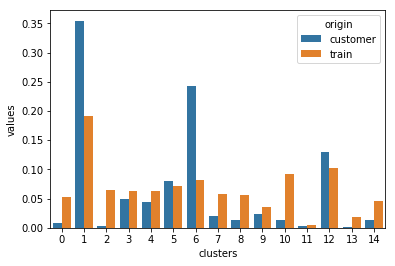

In [13]:
a = df_customer_preds[0].value_counts(normalize=True, sort= False).reset_index()
a['origin'] = 'customer'
b = df_train_preds[0].value_counts(normalize=True, sort=False).reset_index()
b['origin'] = 'general population'
df_clusters = pd.concat([a, b], ignore_index= True)

df_clusters.columns = ['clusters','values','origin']

sns_fig = sns.barplot(data=df_clusters, x= 'clusters', y= 'values', hue= 'origin')
fig = sns_fig.get_figure()
fig.savefig("Images/pecentage_people_customer_general_population.png")

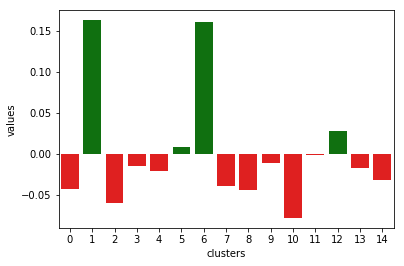

In [14]:
clusters_diff = a[['index',0]].copy()
clusters_diff.columns = ['clusters','values']
clusters_diff['values'] -= b[0]
clusters_diff['less'] = 0
c0 = clusters_diff['values'] < 0 
clusters_diff.loc[c0, 'less'] = 1

colors = ['r' if x < 0 else 'g' for x in clusters_diff['values']]

sns_fig = sns.barplot(data=clusters_diff, x= 'clusters', y= 'values', palette=colors)
fig = sns_fig.get_figure()
fig.savefig("Images/difference_pecentage_people_kmeans_groups.png")

high % customer
> - 1
> - 6

low % customer
> - 10
> - 2

analysis on cluster centers 

In [4]:
# pd.DataFrame(column_names).to_csv('data_transform/column_names.dsv',index=False,sep='|')
column_names = list(pd.read_csv('data_transform/column_names.dsv',sep='|').T.values[0])

In [7]:
stp_kmeans = cluster_pipeline['kmeans']
stp_pca = cluster_pipeline['pca']
stp_transform = cluster_pipeline['transform']
stp_null = cluster_pipeline['null']

cluster_centers = stp_pca.inverse_transform(stp_kmeans.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers, columns= column_names)

stp_categorical = stp_transform.named_transformers_['categorical']
stp_binary = stp_transform.named_transformers_['binary']
stp_ordinal = stp_transform.named_transformers_['ordinal']['ordinal_standarize']

stp_numerical = stp_transform.named_transformers_['numerical']
stp_log = stp_numerical.named_transformers_['log']
stp_log_transform = stp_numerical.named_transformers_['log']['log_transform']
stp_log_scale = stp_numerical.named_transformers_['log']['log_scale']
stp_numeric = stp_numerical.named_transformers_['num']['num_scale']

# Column definitions
dummy_categorical_cols = stp_categorical['cat_onehot'].get_feature_names()
categorical_cols = stp_transform.transformers_[0][2]
binary_cols = stp_transform.transformers_[1][2]
ordinal_cols = stp_transform.transformers_[2][2]
numerical_cols = stp_transform.transformers_[3][2]
log_columns = stp_numerical.transformers_[0][2]
numeric_columns = stp_numerical.transformers_[1][2]

In [7]:
stp_categorical.inverse_transform(cluster_centers[dummy_categorical_cols]).shape

cluster_centers[numeric_columns] = stp_numeric.inverse_transform(cluster_centers[numeric_columns])
cluster_centers[log_columns] = stp_log_scale.inverse_transform(cluster_centers[log_columns])
cluster_centers[log_columns] = stp_log_transform.inverse_transform(cluster_centers[log_columns])
cluster_centers[ordinal_cols] = stp_ordinal.inverse_transform(cluster_centers[ordinal_cols])

df_cat = pd.DataFrame(stp_categorical.inverse_transform(cluster_centers[dummy_categorical_cols]), columns= categorical_cols)
cluster_centers = pd.concat([cluster_centers,df_cat], axis=1)
cluster_centers.drop(columns= dummy_categorical_cols, inplace= True) 

In [17]:
colors_clusters = ['r' if x in [2,10] else 'darkgreen' if x in [1,6] else 'darkgrey' for x in cluster_centers.index.values]
cluster_centers.head()

GREEN_AVANTGARDE  FINANZ_ANLEGER  FINANZ_HAUSBAUER  FINANZ_MINIMALIST  \
0          0.201040        3.066579          2.941130           3.194965   
1          0.061695        2.854398          3.940867           2.045280   
2          0.162924        2.777551          2.031171           4.193607   
3          0.182745        4.298478          3.258016           1.909160   
4          0.298538        3.725129          2.646100           2.777584   

   FINANZ_SPARER  FINANZ_UNAUFFAELLIGER  FINANZ_VORSORGER  HEALTH_TYP  \
0       2.769161               2.689376          3.323558   88.123165   
1       3.471084               2.882134          2.893782   77.802853   
2       2.071933               2.156914          4.015839   35.091639   
3       4.123098               4.080692          2.215373   45.647005   
4       4.085439               4.023101          2.295192   23.897571   

   HH_EINKOMMEN_SCORE  INNENSTADT         ...           RETOURTYP_BK_S  \
0            4.365659   11.880627         ...                      5.0   
1            5.599041    2.205967         ...                      5.0   
2            3.647062    8.047470         ...                      3.0   
3            4.491260    6.950516         ...                      1.0   
4            4.248923    6.085258         ...                      1.0   

   SHOPPER_TYP  VERS_TYP  WOHNLAGE  ZABEOTYP  ANREDE_KZ  ALTERSKATEGORIE_GROB  \
0          1.0       2.0       7.0       3.0        2.0                   3.0   
1          2.0       2.0       3.0       3.0        1.0                   3.0   
2          1.0       1.0       7.0       3.0        2.0                   3.0   
3          2.0       1.0       3.0       4.0        2.0                   2.0   
4          1.0       1.0       3.0       4.0        1.0                   1.0   

   PRAEGENDE_JUGENDJAHRE_MOVEMENT  PLZ8_BAUMAX_FAMILY_BUSINESS  \
0                             0.0                       1965.0   
1                             0.0                          1.0   
2                             0.0                          0.0   
3                             0.0                          0.0   
4                             0.0                          0.0   

   WOHNLAGE_CITY_RURAL  
0                  1.0  
1                  1.0  
2                  2.0  
3                  1.0  
4                  1.0  

[5 rows x 274 columns]

number of rows: 134


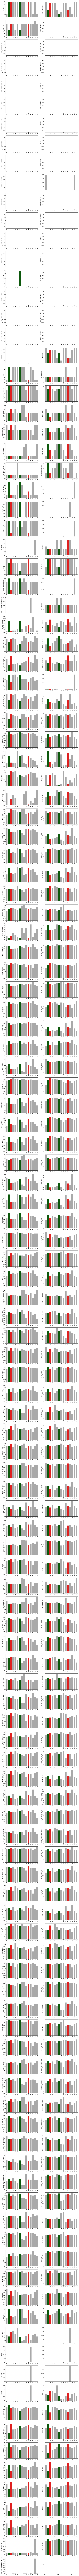

In [20]:
nc = 2
nr = int(np.ceil(len(categorical_cols + binary_cols + ordinal_cols)/nc))

print("number of rows: {}".format(nr))

fig, ax = plt.subplots(nr, nc, figsize=(14, 512))
axs = ax.flatten()
# 1-6 | 10-2
for i,c in enumerate(categorical_cols + binary_cols + ordinal_cols):
#     print(c)
#     print(i)
    
    sns.barplot(data=cluster_centers, x=cluster_centers.index.values, y= c, palette= colors_clusters, ax=axs[i])
    pass

number of rows: 4


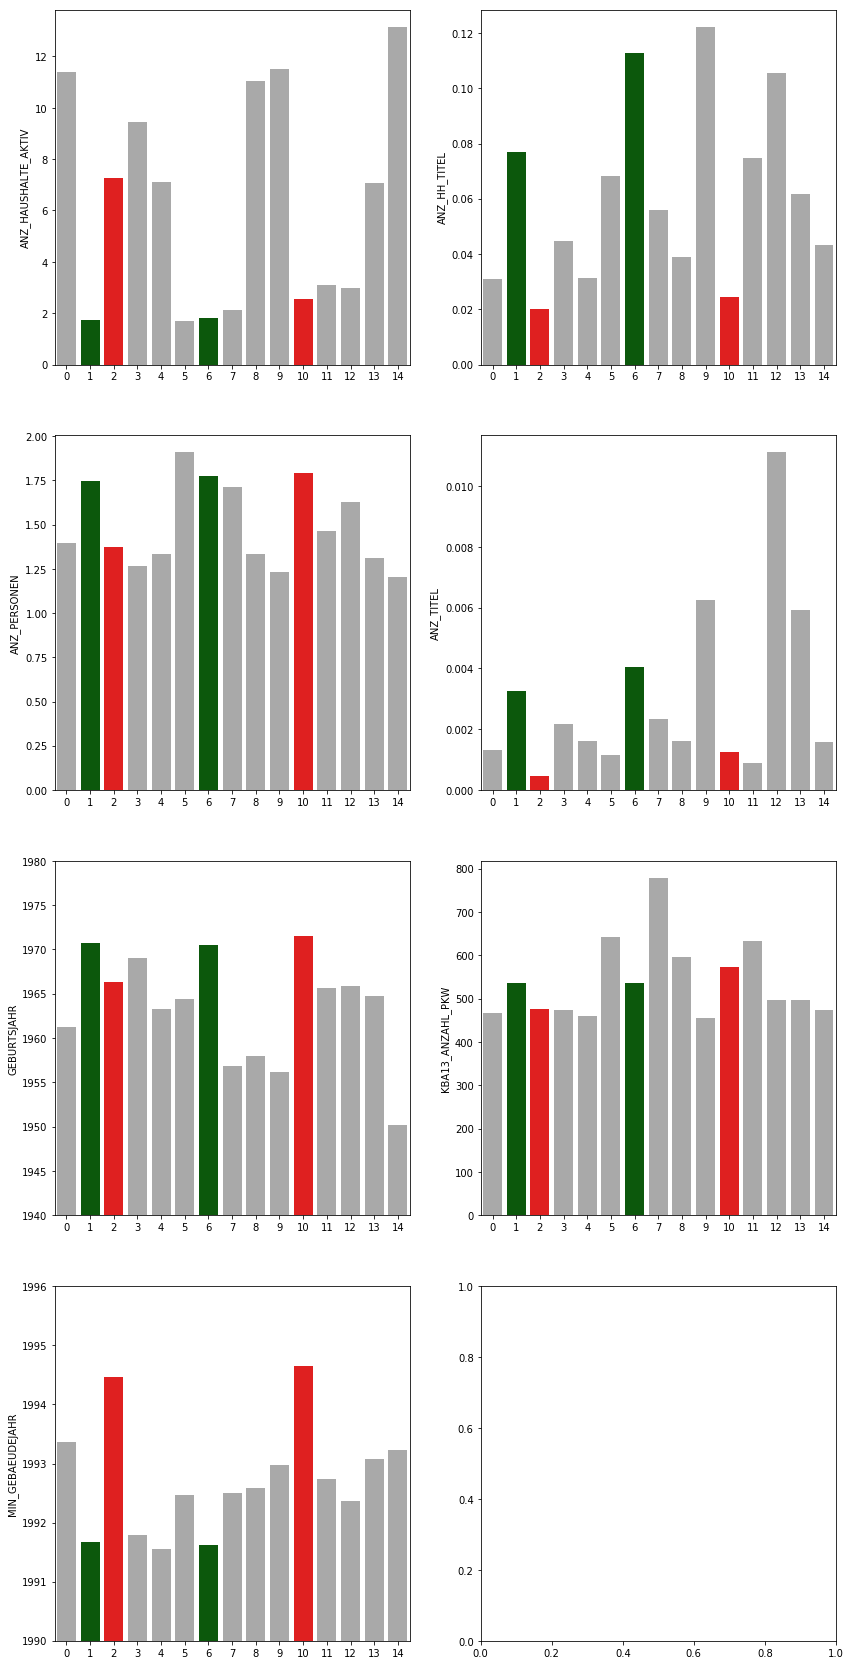

In [21]:
nc = 2
nr = int(np.ceil(len(numerical_cols)/nc))

print("number of rows: {}".format(nr))

fig, ax = plt.subplots(nr, nc, figsize=(14, 30))
axs = ax.flatten()
# 1-6 | 10-2
for i,c in enumerate(numerical_cols):
#     print(c)
#     print(i)
    
    if 'MIN_GEBAEUDEJAHR' in c:
        axs[i].set_ylim(bottom=1990, top = 1996)
    elif 'GEBURTSJAHR' in c:
        axs[i].set_ylim(bottom=1940, top = 1980)
    sns.barplot(data=cluster_centers, x=cluster_centers.index.values, y= c, palette= colors_clusters, ax=axs[i])    
    pass

## over all the azdias dataset

In [22]:
azdias['cluster'] = train_preds

In [25]:
print(len(categorical_cols))
print(len(binary_cols))
print(len(ordinal_cols))

64
1
202


number of rows: 65


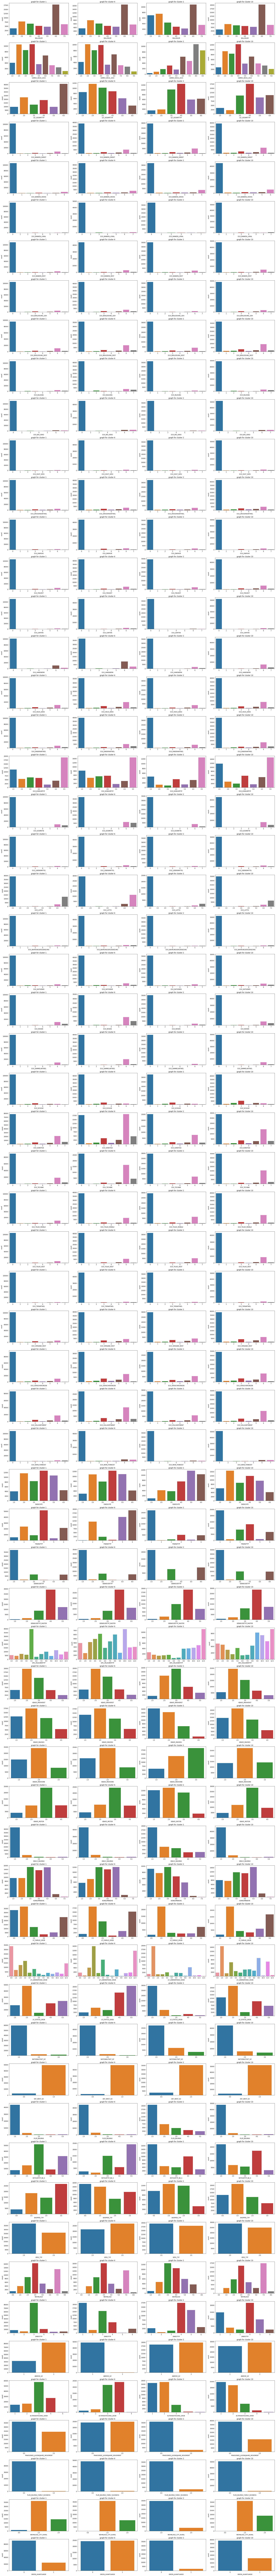

In [28]:
nc = 4
# nr = len(categorical_cols + binary_cols + ordinal_cols)
nr = len(categorical_cols + binary_cols)

print("number of rows: {}".format(nr))

fig, ax = plt.subplots(nr, nc, figsize=(28, 260))
axs = ax.flatten()
# 1-6 | 10-2
# for i,c in enumerate(categorical_cols + binary_cols + ordinal_cols):
for i,c in enumerate(categorical_cols + binary_cols):
    
    c1 = azdias['cluster'] == 1
    c6 = azdias['cluster'] == 6
    c2 = azdias['cluster'] == 2
    c10 = azdias['cluster'] == 10

    i1= i*4+0
    i2= i*4+1
    i3= i*4+2
    i4= i*4+3
    sns.countplot(data=azdias[c1], x= c, ax=axs[i1])
    axs[i1].set_title("graph for cluster {}".format(1))
    
    sns.countplot(data=azdias[c6], x= c, ax=axs[i2])
    axs[i2].set_title("graph for cluster {}".format(6))
    
    sns.countplot(data=azdias[c2], x= c, ax=axs[i3])
    axs[i3].set_title("graph for cluster {}".format(2))
    
    sns.countplot(data=azdias[c10], x= c, ax=axs[i4])
    axs[i4].set_title("graph for cluster {}".format(10))
    pass

fig.tight_layout()

In [29]:
nc = 4
nr = len(ordinal_cols)

print("number of rows: {}".format(nr))

fig, ax = plt.subplots(nr, nc, figsize=(28, 620))
axs = ax.flatten()
# 1-6 | 10-2
for i,c in enumerate(ordinal_cols):
    
    c1 = azdias['cluster'] == 1
    c6 = azdias['cluster'] == 6
    c2 = azdias['cluster'] == 2
    c10 = azdias['cluster'] == 10

    i1= i*4+0
    i2= i*4+1
    i3= i*4+2
    i4= i*4+3
    sns.countplot(data=azdias[c1], x= c, ax=axs[i1])
    axs[i1].set_title("graph for cluster {}".format(1))
    
    sns.countplot(data=azdias[c6], x= c, ax=axs[i2])
    axs[i2].set_title("graph for cluster {}".format(6))
    
    sns.countplot(data=azdias[c2], x= c, ax=axs[i3])
    axs[i3].set_title("graph for cluster {}".format(2))
    
    sns.countplot(data=azdias[c10], x= c, ax=axs[i4])
    axs[i4].set_title("graph for cluster {}".format(10))
    pass

fig.tight_layout()

number of rows: 202


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [8]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  1763         2         1.0       8.0          NaN          NaN   
1  1771         1         4.0      13.0          NaN          NaN   
2  1776         1         1.0       9.0          NaN          NaN   
3  1460         2         1.0       6.0          NaN          NaN   
4  1783         2         1.0       9.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                   8.0                 15.0   
1          NaN          NaN                  13.0                  1.0   
2          NaN          NaN                   7.0                  0.0   
3          NaN          NaN                   6.0                  4.0   
4          NaN          NaN                   9.0                 53.0   

          ...           VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  \
0         ...                5.0         2.0      1.0             6.0   
1         ...                1.0         2.0      1.0             4.0   
2         ...                6.0         4.0      2.0             NaN   
3         ...                8.0        11.0     11.0             6.0   
4         ...                2.0         2.0      1.0             6.0   

   WOHNDAUER_2008  WOHNLAGE  ZABEOTYP RESPONSE ANREDE_KZ ALTERSKATEGORIE_GROB  
0             9.0       3.0         3        0         2                    4  
1             9.0       7.0         1        0         2                    3  
2             9.0       2.0         3        0         1                    4  
3             9.0       1.0         3        0         2                    4  
4             9.0       3.0         3        0         1                    3  

[5 rows x 367 columns]

In [9]:
mailout_train["RESPONSE"].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

Start cleaning data
success: replacing AGER_TYP column keys to Nan
success: replacing ALTERSKATEGORIE_GROB column keys to Nan
success: replacing ALTER_HH column keys to Nan
success: replacing ANREDE_KZ column keys to Nan
success: replacing BALLRAUM column keys to Nan
success: replacing BIP_FLAG column keys to Nan
success: replacing CAMEO_DEUG_2015 column keys to Nan
success: replacing CAMEO_DEUINTL_2015 column keys to Nan
success: replacing CJT_GESAMTTYP column keys to Nan
success: replacing D19_BANKEN_ANZ_12 column keys to Nan
success: replacing D19_BANKEN_ANZ_24 column keys to Nan
success: replacing D19_BANKEN_DATUM column keys to Nan
success: replacing D19_BANKEN_DIREKT_ column keys to Nan
success: replacing D19_BANKEN_GROSS_ column keys to Nan
success: replacing D19_BANKEN_LOKAL_ column keys to Nan
success: replacing D19_BANKEN_OFFLINE_DATUM column keys to Nan
success: replacing D19_BANKEN_ONLINE_DATUM column keys to Nan
success: replacing D19_BANKEN_ONLINE_QUOTE_12 column keys to 

success: replacing SEMIO_LUST column keys to Nan
success: replacing SEMIO_MAT column keys to Nan
success: replacing SEMIO_PFLICHT column keys to Nan
success: replacing SEMIO_RAT column keys to Nan
success: replacing SEMIO_REL column keys to Nan
success: replacing SEMIO_SOZ column keys to Nan
success: replacing SEMIO_TRADV column keys to Nan
success: replacing SEMIO_VERT column keys to Nan
success: replacing SHOPPER_TYP column keys to Nan
success: replacing SOHO_FLAG column keys to Nan
success: replacing TITEL_KZ column keys to Nan
success: replacing VERS_TYP column keys to Nan
success: replacing WOHNDAUER_2008 column keys to Nan
success: replacing WOHNLAGE column keys to Nan
success: replacing WACHSTUMSGEBIET_NB column keys to Nan
success: replacing W_KEIT_KIND_HH column keys to Nan
success: replacing ZABEOTYP column keys to Nan
Dropping columns with high percetnage of missing values
ammount of dropped columns: 34
remaining columns: 333
END removing columns high percetnage of missing v

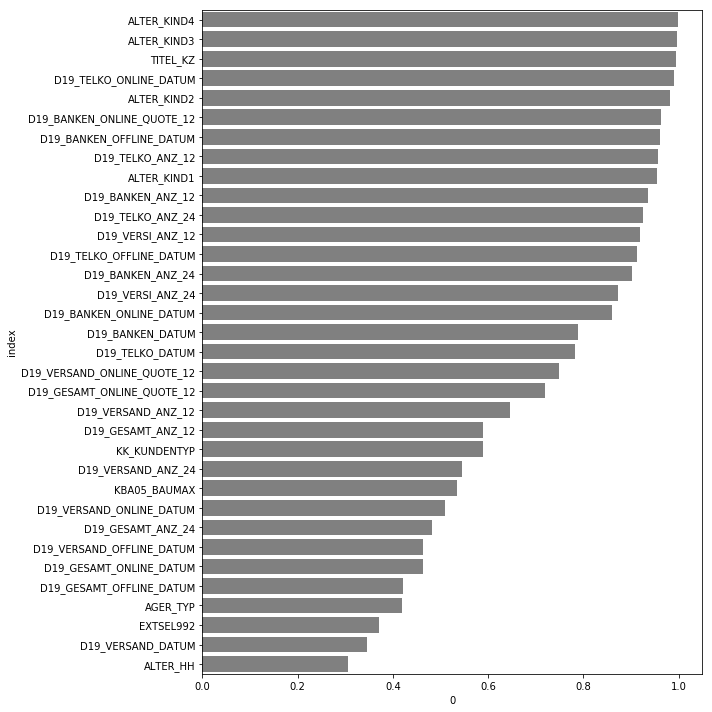

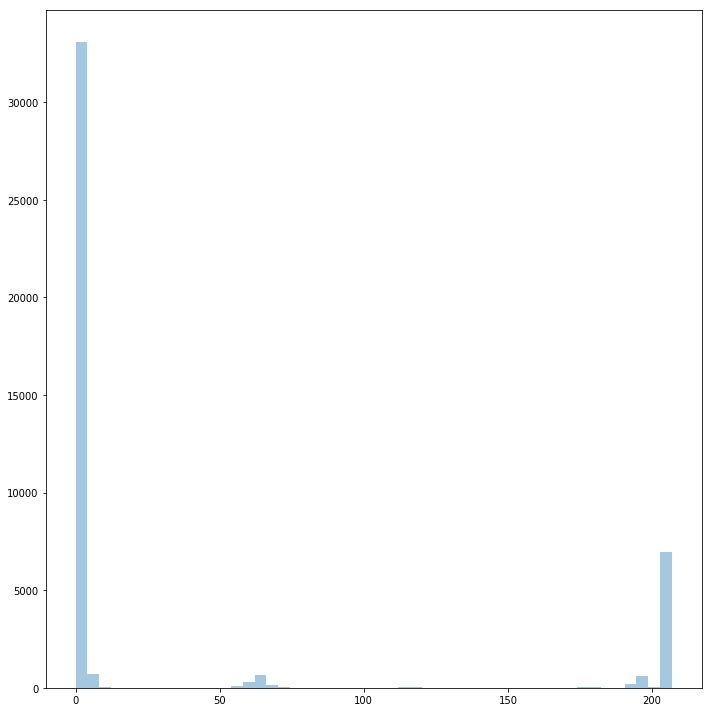

In [10]:
mailout_train = data_transform.clean_transform_data(mailout_train, train= True)

mailout_train.drop(columns=['D19_GESAMT_DATUM'],inplace= True)

y_train = mailout_train["RESPONSE"]
X_train = mailout_train.drop(["RESPONSE"], axis=1)

In [11]:
[x for x in X_train.columns.values if x not in azdias.columns.values]
# [x for x in azdias.columns.values if x not in X_train.columns.values]

NameError: name 'azdias' is not defined

In [15]:
transform_pipeline = Pipeline([
        ('null',stp_null),
        ('transform', stp_transform), 
        ('pca', stp_pca)])

In [16]:
X_train_transformed = transform_pipeline.transform(X_train)

In [12]:
# ct = ColumnTransformer(transformers=transformers)
ct = stp_transform
X_train_transformed = ct.transform(X_train)

In [17]:
X_preds = cluster_pipeline.predict(X_train)
X_preds

array([12,  2,  7, ...,  9,  6,  9], dtype=int32)

In [18]:
print(type(X_train_transformed))
print(X_train_transformed.shape)
print(X_preds.shape)

<class 'numpy.ndarray'>
(33837, 175)
(33837,)


In [19]:
X_train2=np.append(X_train_transformed,np.atleast_2d(X_preds).T,axis=1)

In [13]:
pd.DataFrame(X_train_transformed, columns= column_names)[ordinal_cols].isna().sum().sum()

0

Roc_auc train score = 1.0
Roc_auc validation score = 0.53



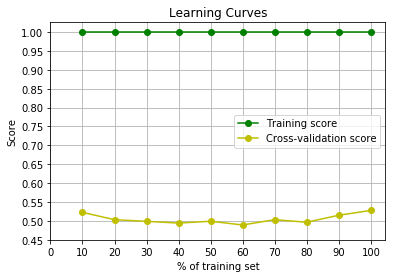

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve

m = RandomForestClassifier(random_state=42)
num_trainings = 10
    
train_sizes, train_scores, test_scores = learning_curve(
m, X_train_transformed, y_train, cv=None, scoring = 'roc_auc', train_sizes=np.linspace(.1, 1.0, num_trainings))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
print("Roc_auc train score = {}".format(train_scores_mean[-1].round(2)))
print("Roc_auc validation score = {}".format(test_scores_mean[-1].round(2)))
plt.grid()

plt.title("Learning Curves")
plt.xlabel("% of training set")
plt.ylabel("Score")

plt.plot(np.linspace(.1, 1.0, num_trainings)*100, train_scores_mean, 'o-', color="g",
         label="Training score")
plt.plot(np.linspace(.1, 1.0, num_trainings)*100, test_scores_mean, 'o-', color="y",
         label="Cross-validation score")

plt.yticks(np.arange(0.45, 1.02, 0.05))
plt.xticks(np.arange(0., 100.05, 10))
plt.legend(loc="best")
print("")
plt.show()

###############################################################################

In [22]:
m.fit(X_train_transformed, y_train)

y_pred = m.predict(X_train_transformed)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

cv_score = cross_val_score(m, X_train_transformed, y_train, cv=10, scoring='roc_auc')


print(confusion_matrix(y_train, y_pred))

[[33421     0]
 [    2   414]]


In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

models = {'RandomForestClassifier': RandomForestClassifier(random_state=42), 
          'AdaBoostClassifier': AdaBoostClassifier(random_state=42), 
          'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42)
         }

RandomForestClassifier
RandomForestClassifier(random_state=42)
Roc_auc train score = 1.0
Roc_auc validation score = 0.53



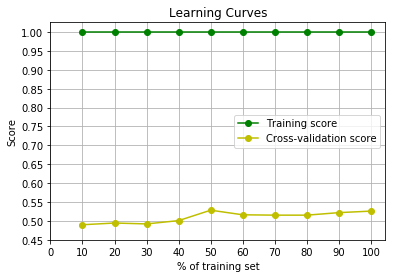

AdaBoostClassifier
AdaBoostClassifier(random_state=42)
Roc_auc train score = 0.79
Roc_auc validation score = 0.61



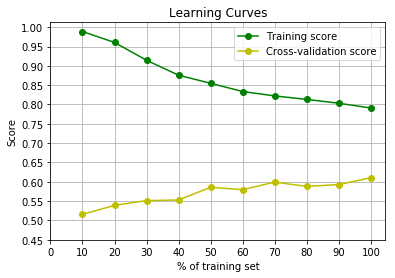

GradientBoostingClassifier
GradientBoostingClassifier(random_state=42)
Roc_auc train score = 0.95
Roc_auc validation score = 0.62



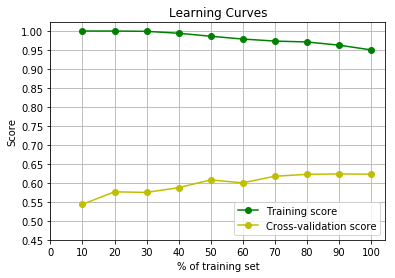

In [24]:
models = {'RandomForestClassifier': RandomForestClassifier(random_state=42), 
          'AdaBoostClassifier': AdaBoostClassifier(random_state=42), 
          'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42)
         }

for k,m in models.items():
    print(k)
    print(m)
  
    
    train_sizes, train_scores, test_scores = learning_curve(
    m, X_train_transformed, y_train, cv=None, scoring = 'roc_auc', train_sizes=np.linspace(.1, 1.0, num_trainings))

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    print("Roc_auc train score = {}".format(train_scores_mean[-1].round(2)))
    print("Roc_auc validation score = {}".format(test_scores_mean[-1].round(2)))
    plt.grid()

    plt.title("Learning Curves")
    plt.xlabel("% of training set")
    plt.ylabel("Score")

    plt.plot(np.linspace(.1, 1.0, num_trainings)*100, train_scores_mean, 'o-', color="g",
             label="Training score")
    plt.plot(np.linspace(.1, 1.0, num_trainings)*100, test_scores_mean, 'o-', color="y",
             label="Cross-validation score")

    plt.yticks(np.arange(0.45, 1.02, 0.05))
    plt.xticks(np.arange(0., 100.05, 10))
    plt.legend(loc="best")
    print("")
    plt.show()
    
    
    m.fit(X_train_transformed, y_train)

In [28]:
gbc.get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

#initialize pipeline with GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state=42)

parameters = {'learning_rate': [0.1, 0.01], 'n_estimators': [100,150], 
              'max_depth': [3], 'min_samples_split': [2]}
        
        
grid_obj = GridSearchCV(gbc, parameters, scoring = 'roc_auc',verbose=3)

# Fit the grid search object to the training data and find the optimal parameters
grid_obj.fit(X_train_transformed, y_train)

# Get the estimator and predict
print(grid_obj.best_params_)
best_clf = grid_obj.best_estimator_
best_predictions = best_clf.predict_proba(X_train_transformed)[:, 1]

# Make predictions using unoptimized and the best model
predictions = (gbc.fit(X_train_transformed, y_train)).predict_proba(X_train_transformed)[:, 1]

print("Roc_auc score on training data: {:.4f}".format(roc_auc_score(y_train, predictions)))
print("Final Roc_auc score on the training data: {:.4f}".format(roc_auc_score(y_train, best_predictions)))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100; total time= 2.5min
[CV 2/5] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100; total time= 2.3min
[CV 3/5] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100; total time= 2.0min
[CV 4/5] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100; total time= 2.0min
[CV 5/5] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100; total time= 2.0min
[CV 1/5] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=150; total time= 3.0min
[CV 2/5] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=150; total time= 2.8min
[CV 3/5] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=150; total time= 2.8min
[CV 4/5] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=150; total time= 2.8min
[CV 5/5] END 

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [19]:
from sklearn.metrics import roc_auc_score

print(grid_obj.best_params_)
best_clf = grid_obj.best_estimator_
best_predictions = best_clf.predict_proba(X_train_transformed)[:, 1]

# Make predictions using unoptimized and the best model
predictions = (gbc.fit(X_train_transformed, y_train)).predict_proba(X_train_transformed)[:, 1]

print("Roc_auc score on training data: {:.4f}".format(roc_auc_score(y_train, predictions)))
print("Final Roc_auc score on the training data: {:.4f}".format(roc_auc_score(y_train, best_predictions)))

{'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
Roc_auc score on training data: 0.9281
Final Roc_auc score on the training data: 0.7239


In [47]:
gbc = GradientBoostingClassifier(random_state=42)
gbc = GradientBoostingClassifier(random_state=42,learning_rate= 0.01, max_depth= 3, min_samples_split= 2, n_estimators= 100)

predictions = (gbc.fit(X_train_transformed, y_train)).predict_proba(X_train_transformed)[:, 1]
predictions2 = (gbc.fit(X_train2, y_train)).predict_proba(X_train2)[:, 1]

print("Roc_auc score on training data: {:.4f}".format(roc_auc_score(y_train, predictions)))
print("Roc_auc score on training data: {:.4f}".format(roc_auc_score(y_train, predictions2)))


Roc_auc score on training data: 0.7239
Roc_auc score on training data: 0.7239


In [53]:
gbc.predict_proba(X_train2)[0,:].sum()

1.0

In [20]:
pkl_filename = "Model/supervised_best_model.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(best_clf, file)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')